In [1]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from stepmix.stepmix import StepMix
import re


/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Summary of missingness

Let's first look at the state of the training data and see how many missing there are for each target. 

In [2]:
train = pd.read_csv('data/train_data.csv')
train.isna().sum(axis=0)

CXSMILES         0
MDR1-MDCKII      9
LogD            82
KSOL            69
MLM            131
HLM            133
dtype: int64

The missing values represent either assays that haven't been run (true missing) or are above or below the assay detection limits (censored). 
With the correct model (e.g., ordinal regression) censored data can be utilised.  So I'm gonna get the censored values back in.  Unfortunately we can't use the SMILES strings because they aren't unique, as there are unknown stereochemistries: 

In [3]:
print(f"num obs: {train.shape[0]}, num unique smiles: {len(set(train['CXSMILES']))}")

vals, idx, counts = np.unique(train['CXSMILES'].values, return_counts=True, return_index=True)
print(f"num mols with 2 enantiomers: {vals[counts==2].shape[0]}")

num obs: 434, num unique smiles: 404
num mols with 2 enantiomers: 30


These are labelled with the 'OR' stereochemistry in CXSMILES: 

In [4]:
vals[counts==2][:2]

array(['CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=C1 |o1:4|',
       'CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=N1 |o1:4|'],
      dtype=object)

So we will need to use the molecule name. 

In [8]:
challenge = "antiviral-admet-2025"

competition = po.load_competition(f"asap-discovery/antiviral-admet-2025")
competition.cache()
train, test = competition.get_train_test_split()


[2025-02-20 12:08:46] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=79208;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=591666;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=332737;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=212516;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:08:46] Copying to destination                                                                      ]8;id=270757;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=678801;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /Users/robertarbon/Library/Caches/polaris/datasets/ba779145-2d4f-406c-968b-b6045a28ff11/dat             
           a.zarr                                                                                                  

           For large Zarr archives, this may take a while.                                             ]8;id=957553;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=406782;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#381\381]8;;\

[12:08:47]  Success: Copying Zarr keys                                                                ]8;id=305175;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=730326;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=415242;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=813907;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [9]:
columns = train.dataset.columns
n_rows = train.dataset.n_rows

data = {k: [train.dataset.get_data(i, k) for i in range(n_rows)] for k in columns}
df = pd.DataFrame(data)

This data includes all the molecules for which there are no measured values. 

In [10]:
df.tail()

,CXSMILES,HLM,KSOL,LogD,MDR1-MDCKII,MLM,Molecule Name
555,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,NaN,NaN,NaN,NaN,NaN,ASAP-0014770
556,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,NaN,NaN,NaN,NaN,NaN,ASAP-0014773
557,COC[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN...,NaN,NaN,NaN,NaN,NaN,ASAP-0014789
558,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,NaN,NaN,NaN,NaN,NaN,ASAP-0014632
559,CC1=NC=C(CN2C[C@@]3(C(=O)N(C4=CN=CC5=CC=CC=C45...,NaN,NaN,NaN,NaN,NaN,ASAP-0014619


In [11]:
df['n_missing'] = df.isna().sum(axis=1)
df.loc[df.n_missing < 5, :].shape

(434, 8)

Now we can fetch all the censored values from the raw data

In [12]:
target_to_raw = {'MLM': 
                    {'measurement_col': 'in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)', 
                     'mod_col': 'in-vitro_MLM_bienta: CLint (Mod)', 
                     'train_name': 'MLM'},
                  'HLM':
                     {'measurement_col': 'in-vitro_HLM_bienta: CLint (Num) (uL/min/mg)', 
                      'mod_col': 'in-vitro_HLM_bienta: CLint (Mod)', 
                      'train_name': 'HLM'}, 
                  'KSOL':
                     {'measurement_col': 'in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM)', 
                     'mod_col': 'in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)', 
                     'train_name': 'KSOL'},   
                  'LogD':
                     {'measurement_col': 'in-vitro_LogD_bienta: LogD (Num)', 
                     'mod_col': 'in-vitro_LogD_bienta: LogD (Mod)', 
                     'train_name': 'LogD'}, 
                  'MDR1-MDCK2':
                     {'measurement_col': 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s)', 
                     'mod_col': 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod)', 
                     'train_name': 'MDR1-MDCKII'},   
                 }




In [17]:
data = {k: [train.dataset.get_data(i, k) for i in range(n_rows)] for k in columns}
df = pd.DataFrame(data)
old_n_missing = df.loc[:, list(train.target_cols)].isna().sum(axis=1)

dupes_to_check = {}

for target in target_to_raw.keys():

    raw = pd.read_csv(f'raw_data_package/admet/ADMET_{target}_CONFIDENTIAL.csv')

    to_merge = raw.loc[:, ['Molecule Name', target_to_raw[target]['measurement_col'],target_to_raw[target]['mod_col'], 'CXSMILES (CDD Compatible)']]


    not_eqs_symbs = to_merge[target_to_raw[target]['mod_col']].unique()
    not_eqs_symbs = [x for x in not_eqs_symbs if x !='=']

    to_merge = to_merge.loc[to_merge[target_to_raw[target]['mod_col']].isin(not_eqs_symbs), :]

    duplicates = to_merge.duplicated(keep=False)

    to_merge = to_merge.drop_duplicates()

    dupes_to_check[target] = duplicates

    # Check whether 'censored' value really is out of the range of the other values
    min_cval, max_cval = to_merge[target_to_raw[target]['measurement_col']].min(), to_merge[target_to_raw[target]['measurement_col']].max()
    min_val, max_val = df[target_to_raw[target]['train_name']].min(), df[target_to_raw[target]['train_name']].max()

    if (min_val < min_cval) or (max_val > max_cval): 
        print(f"{target}: {min_val}<{min_cval}, {max_val}>{max_cval}.  Can't combine these observations.")
        continue

    

    # Check merging process
    old_n = df.shape[0]

    tmp = df.merge(right=to_merge, on='Molecule Name', how='left')
    new_n = tmp.shape[0]
    ix = tmp['CXSMILES (CDD Compatible)'].isna()
    tmp.loc[ix, 'CXSMILES (CDD Compatible)'] = tmp.loc[ix, 'CXSMILES']

    smiles_matching = np.all(tmp['CXSMILES (CDD Compatible)'].values == tmp['CXSMILES'].values)

    if (old_n == new_n) and smiles_matching: 
        df = tmp
        target_na = df[target_to_raw[target]['train_name']].isna()
        
        # update missing values
        df.loc[target_na, target_to_raw[target]['train_name']] = df.loc[target_na, target_to_raw[target]['measurement_col']].values
        del df['CXSMILES (CDD Compatible)']

    else: 
        print('ERROR', old_n, new_n, smiles_matching, target)
        print(target,' not added to dataset')
        pass 



new_n_missing =  df.loc[:, list(train.target_cols)].isna().sum(axis=1)
print(old_n_missing.sum() - new_n_missing.sum())
df = df.loc[new_n_missing<5, :]
df.shape


MLM: 0.0<10.0, 2380.0>10.0.  Can't combine these observations.
HLM: 0.0<10.0, 1620.0>10.0.  Can't combine these observations.
70


(434, 13)

In [18]:
df.head()

,CXSMILES,HLM,KSOL,LogD,MDR1-MDCKII,MLM,Molecule Name,in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM),in-vitro_KSOL-PBS_bienta: mean_solubility (Mod),in-vitro_LogD_bienta: LogD (Num),in-vitro_LogD_bienta: LogD (Mod),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s),in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod)
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,400.0,0.3,2.0,NaN,ASAP-0032437,400.0,≥,NaN,NaN,NaN,NaN
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,0.2,NaN,ASAP-0031915,NaN,NaN,NaN,NaN,NaN,NaN
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,400.0,0.4,0.5,NaN,ASAP-0031884,400.0,≥,NaN,NaN,NaN,NaN
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,8.5,NaN,ASAP-0031848,NaN,NaN,NaN,NaN,NaN,NaN
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,0.9,NaN,ASAP-0031813,NaN,NaN,NaN,NaN,NaN,NaN


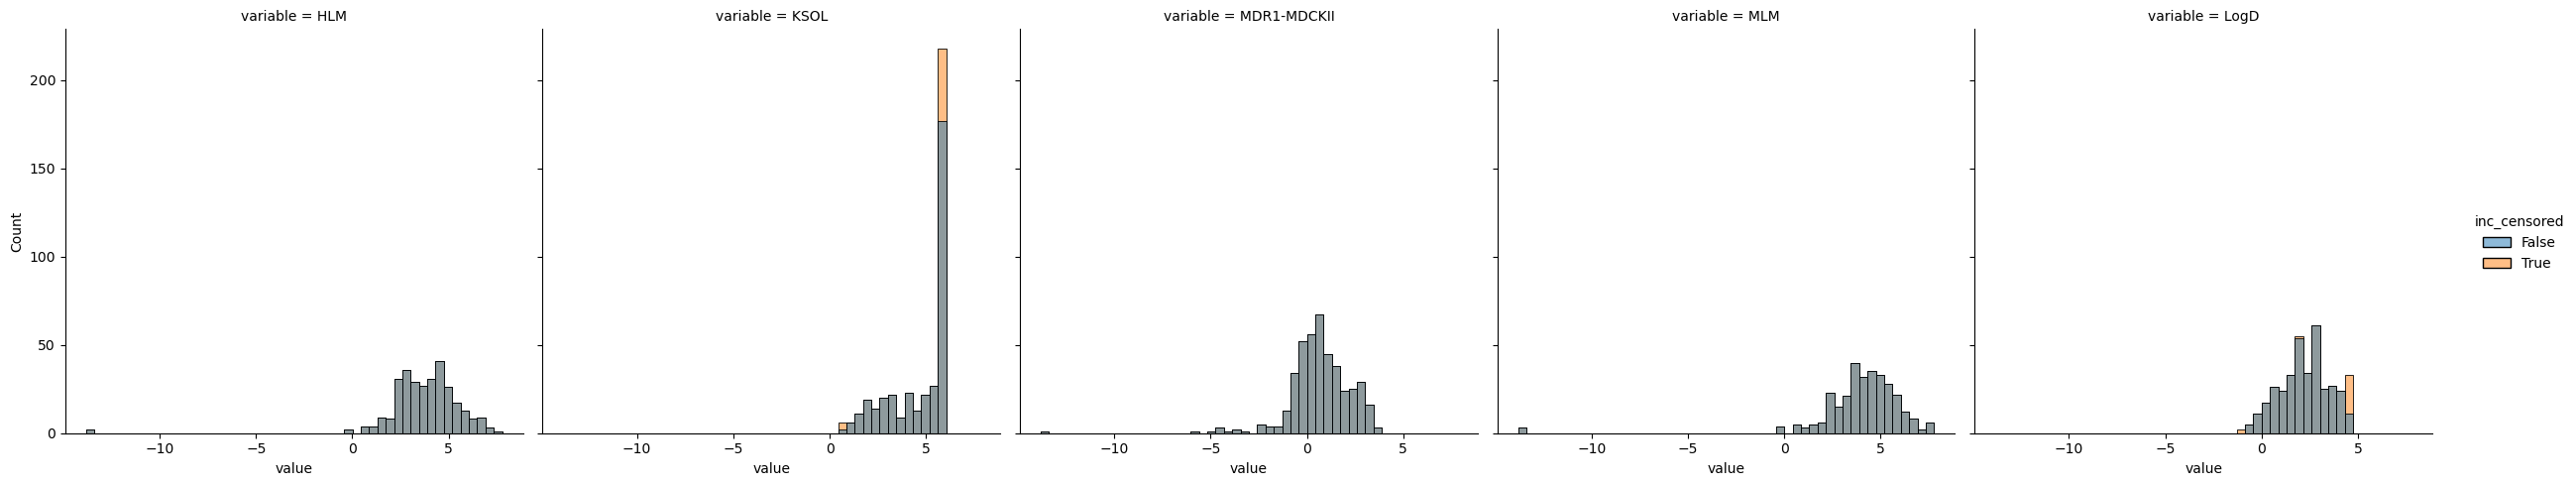

In [20]:
to_plot = df.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM', 'LogD']]
to_plot['inc_censored'] = True
tmp = pd.read_csv('data/train_data.csv')
tmp['inc_censored'] = False
to_plot = pd.concat([tmp.loc[:,['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM', 'LogD', 'inc_censored'] ], to_plot], axis=0)

to_plot.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM']] = np.log(to_plot.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM']] + 1e-6)


sns.displot(data=to_plot.melt(id_vars='inc_censored'), x='value', col='variable', hue='inc_censored')

In [21]:
df.to_csv('data/train_inc_censored.csv', index=False)